In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


ValueError: x and y must be the same size

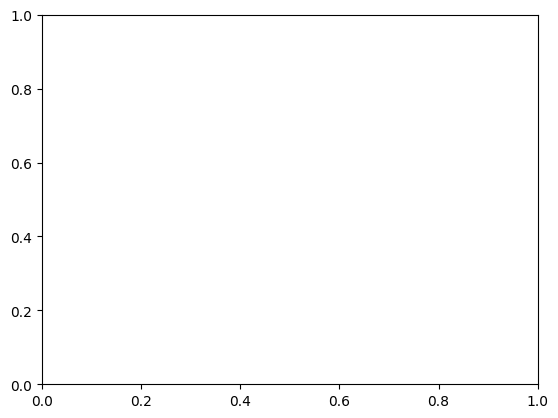

In [8]:


# Create synthetic data
def create_synthetic_data(n_samples=1000):
    # Create two clusters for class 0 and 1, with an ambiguous region in between
    X_class0 = np.random.normal(loc=-2, scale=0.5, size=(n_samples//2, 2))
    X_class1 = np.random.normal(loc=2, scale=0.5, size=(n_samples//2, 2))
    
    X = np.vstack([X_class0, X_class1])
    y = np.hstack([np.zeros(n_samples//2), np.ones(n_samples//2)])
    
    # Add some noisy points in between clusters
    noise_points = np.random.uniform(low=-1, high=1, size=(n_samples//4, 2))
    noise_labels = np.random.binomial(n=1, p=0.5, size=n_samples//4)
    
    X = np.vstack([X, noise_points])
    y = np.hstack([y, noise_labels])
    
    return torch.FloatTensor(X), torch.LongTensor(y)

X, y = create_synthetic_data()

# Plot
plt.scatter(X, y)



In [ ]:

# Define model with MC Dropout
class MCDropoutNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout_rate = dropout_rate
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout_rate, training=True)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=self.dropout_rate, training=True)
        x = self.fc3(x)
        return torch.sigmoid(x)

# Create model
model = MCDropoutNet()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Train model
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs.squeeze(), y.float())
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Evaluate with MC Dropout
model.eval()  # Note: dropout still active due to training=True in forward
n_samples = 100
predictions = []

with torch.no_grad():
    for _ in range(n_samples):
        pred = model(X)
        predictions.append(pred)

# Calculate mean and uncertainty
predictions = torch.stack(predictions, dim=0)
mean_pred = predictions.mean(dim=0).squeeze()
uncertainty = predictions.std(dim=0).squeeze()

# Calculate binary prediction and error
binary_pred = (mean_pred > 0.5).float()
error = (binary_pred != y.float()).float()

# Calculate correlations
corr, p_value = pearsonr(uncertainty.numpy(), error.numpy())
print(f"\nCorrelation between uncertainty and error: {corr:.4f} (p-value: {p_value:.4f})")

# Calculate AUC for uncertainty as error predictor
auc = roc_auc_score(error.numpy(), uncertainty.numpy())
print(f"AUC of uncertainty as error predictor: {auc:.4f}")


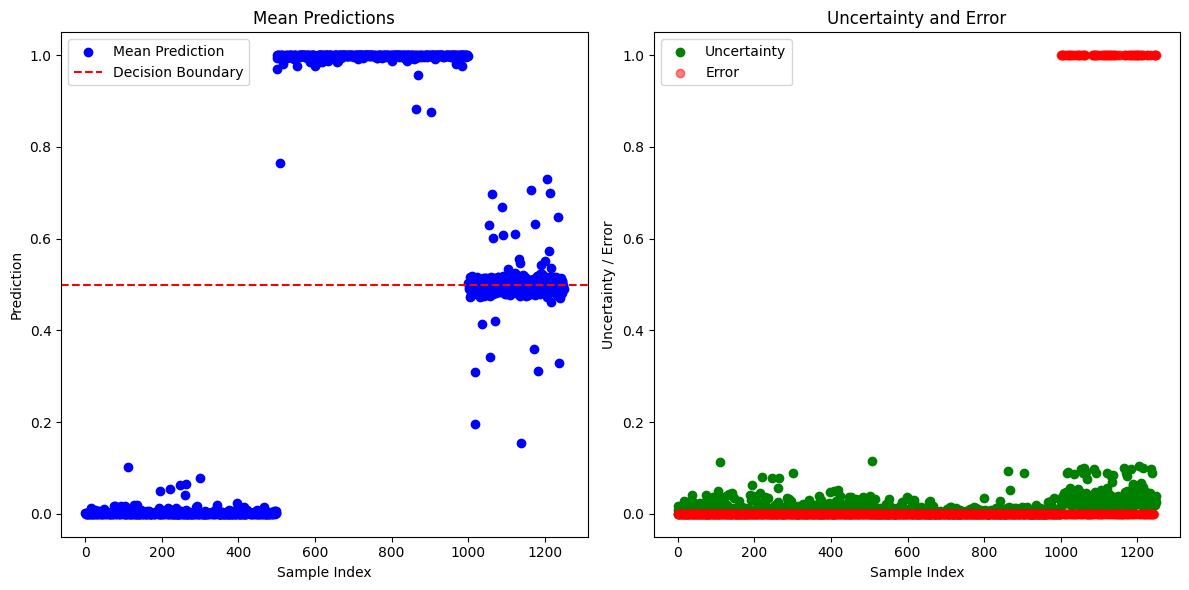

In [5]:
plt.figure(figsize=(12, 6))

# Plot mean predictions
plt.subplot(1, 2, 1)
plt.scatter(range(len(mean_pred)), mean_pred.numpy(), c='blue', label='Mean Prediction')
plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Boundary')
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Mean Predictions')
plt.legend()

# Plot uncertainty and error
plt.subplot(1, 2, 2)
plt.scatter(range(len(uncertainty)), uncertainty.numpy(), c='green', label='Uncertainty')
plt.scatter(range(len(error)), error.numpy(), c='red', label='Error', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Uncertainty / Error')
plt.title('Uncertainty and Error')
plt.legend()
plt.tight_layout()
plt.show()